# Extension: Identification of Hate Speech and Offensive Language with a Multi-Class RNN
**Authors:** Chloe Maine, Drena Mitfari and Kristin Lomicka\
**Date:** February 28, 2020

This notebook contains the code for our multi-class RNN and is an extension of the Sentiment Analysis project presented in the 'sentiment_analysis_chloe_drena_kristin.ipynb' notebook. The methodology and results and described there, while this notebook contains the code for the data preparation, models, training, testing and results. 

In [147]:
# Import required packages
import torch
from torch import nn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

## Load and prepare data

In [2]:
# load data
file_loc = "/Users/chloemaine/Documents/Chloe/BGSE/computational_ml_t2/pytorch_carlos/git_pull/data"
os.chdir(file_loc)

df = pd.read_csv("labeled_data.csv")
doclist_idx = np.load("doclist_idx_lg_padded.npy", allow_pickle = True) # doc list with words represented by index #
word_list = np.load("unique_words_lg.npy", allow_pickle = True) # list of unique words
doclist_onehot_lg = np.load("doclist_onehot_lg.npy", allow_pickle = True)

In [3]:
# Train/test split - Respecting sampling ratios in each class

train_ratio = 0.8

# Subset Ys

df_c0 = df.loc[df['class'] == 0]
df_c1 = df.loc[df['class'] == 1]
df_c2 = df.loc[df['class'] == 2]

len_df_c0 = df_c0.shape[0]
len_df_c1 = df_c1.shape[0]
len_df_c2 = df_c2.shape[0]

train_cutoff_c0 = int(len_df_c0 * train_ratio)
train_cutoff_c1 = int(len_df_c1 * train_ratio)
train_cutoff_c2 = int(len_df_c2 * train_ratio)

Y_train_c0 = df_c0.iloc[:train_cutoff_c0, 5]
Y_test_c0 =  df_c0.iloc[train_cutoff_c0:, 5]
Y_train_c1 =  df_c1.iloc[:train_cutoff_c1, 5]
Y_test_c1 =  df_c1.iloc[train_cutoff_c1:, 5]
Y_train_c2 =  df_c2.iloc[:train_cutoff_c2, 5]
Y_test_c2 =  df_c2.iloc[train_cutoff_c2:, 5]


Y_train = pd.concat([Y_train_c0, Y_train_c1, Y_train_c2], axis=0)
Y_test =  pd.concat([Y_test_c0, Y_test_c1, Y_test_c2], axis=0)

# Subset Xs

X_c0 = doclist_idx[df['class'] == 0]
X_c1 = doclist_idx[df['class'] == 1]
X_c2 = doclist_idx[df['class'] == 2]

X_train_c0 = X_c0[:train_cutoff_c0]
X_test_c0 = X_c0[train_cutoff_c0:]
X_train_c1 = X_c1[:train_cutoff_c1]
X_test_c1 =  X_c1[train_cutoff_c1:]
X_train_c2 = X_c2[:train_cutoff_c2]
X_test_c2 =  X_c2[train_cutoff_c2:]

X_test =  np.concatenate([X_test_c0, X_test_c1, X_test_c2], axis=0)
X_train = np.concatenate([X_train_c0, X_train_c1, X_train_c2], axis=0)

In [4]:
# Convert input and target lists to tensors
# Convert wordlist to dictionary

input_seq = torch.from_numpy(np.asarray(X_train))
target_seq = torch.Tensor(np.asarray(Y_train))
word_dict = { i : word_list[i] for i in range(0, len(word_list) ) }

# print(word_dict)

## Model definition and training

In [5]:
# Build feature in Pytorch to determine whether we are running on a GPU or CPU

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### Single layer, multi-class RNN

In [101]:
# Single layer NN

class Model(nn.Module):
    def __init__(self, dict_size, embedding_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding_size = embedding_size
        #defining embedding
            # The number of embeddings should be the dictionary size
        self.embedding = nn.Embedding(num_embeddings=dict_size, embedding_dim=embedding_size)
        
        #Defining the layers

        self.rnn = nn.RNN(embedding_size, hidden_dim, n_layers, batch_first=True)   
            
        self.fc = nn.Linear(hidden_dim, output_size)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        #compute embedding
        x = self.embedding(x)  #x is bs,max_seq_len,embedding size

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, last_state)   
    
        out = torch.mean(out, dim=1)
        
        out = self.sigmoid(out)
        
        return out, hidden
    

### Training: Single layer multi-class model

In [102]:
dict_size = len(word_dict)

# Instantiate the model with hyperparameters
model = Model(dict_size = dict_size, embedding_size=100, output_size=3, hidden_dim=3, n_layers=1)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 20
lr=0.01

# Define weights to address class imbalance
weights = torch.tensor([1/train_cutoff_c0, 1/train_cutoff_c1, 1/train_cutoff_c2])
criterion_weighted = nn.CrossEntropyLoss(weight=weights)

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Model 1: Multiclass model; 1 layer; no weights

In [ ]:
# Training Run

input_seq = input_seq.to(device)
target_seq = target_seq.to(device)

n_epochs= 500

loss_values_1dim = []
for epoch in range(1, n_epochs + 1):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch
#     input_seq = input_seq.to(device)

    output, hidden = model(input_seq)
#     output = output.to(device)

    loss = criterion(output, target_seq.long())
    loss_values_1dim.append(loss)
    
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

l1_nw_pickle = open("l1_nw_pickle", "wb")
pickle.dump([model, loss_values_1dim], l1_nw_pickle)

#### Model 2: Multi-class model; 1 layers; weights = 1/class

In [77]:
# Training Run

input_seq = input_seq.to(device)
target_seq = target_seq.to(device)

n_epochs=500

loss_values_1dim_w = []
for epoch in range(1, n_epochs + 1):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch
#     input_seq = input_seq.to(device)

    output, hidden = model(input_seq)
#     output = output.to(device)

    loss = criterion(output, target_seq.long())
    loss_values_1dim_w.append(loss)
    
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

l1_w_pickle = open("l1_w_pickle", "wb")
pickle.dump([model, loss_values_1dim_w], l1_w_pickle)

### Three layer multi-class RNN

In [98]:
# 3 layer multiclass network

class Model(nn.Module):
    def __init__(self, dict_size, embedding_size, output_size,  n_layers,hidden_dim1=10, hidden_dim2=10, hidden_dim3=10):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.n_layers = n_layers

        self.embedding_size = embedding_size
        #defining embedding
            # The number of embeddings should be the dictionary size
        self.embedding = nn.Embedding(num_embeddings=dict_size, embedding_dim=embedding_size)
        
        #Defining the layers

        self.rnn1 = nn.RNN(embedding_size, hidden_dim1, n_layers, batch_first=True, nonlinearity = "relu") 
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, n_layers, batch_first=True, nonlinearity = "relu") 
        self.rnn3 = nn.RNN(hidden_dim2, hidden_dim3, n_layers, batch_first=True, nonlinearity = "relu") 
        
        self.fc = nn.Linear(hidden_dim3, output_size)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        #compute embedding
        x = self.embedding(x)  #x is bs,max_seq_len,embedding size

        # Passing in the input and hidden state into the model and obtaining outputs
        x, hidden = self.rnn1(x, last_state)
        x, hidden = self.rnn2(x, last_state) 
        out, hidden = self.rnn3(x, last_state) 
    
        out = torch.mean(out, dim=1)
        
        out = self.sigmoid(out)
        
        return out, hidden
 

### Training: Three layer multi-class RNN

In [99]:
dict_size = len(word_dict)

# Instantiate the model with hyperparameters
model = Model(dict_size = dict_size, embedding_size=100, output_size=3,hidden_dim1=3, hidden_dim2=3, hidden_dim3=3, n_layers=1)
 

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 20
lr=0.01

# Define weights to address class imbalance
weights = torch.tensor([1/train_cutoff_c0, 1/train_cutoff_c1, 1/train_cutoff_c2])
criterion_weighted = nn.CrossEntropyLoss(weight=weights)

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Multi-class model; 3 layers; no weights

In [69]:
# Training Run

input_seq = input_seq.to(device)
target_seq = target_seq.to(device)

n_epochs=500

loss_values_3dim = []
for epoch in range(1, n_epochs + 1):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch
#     input_seq = input_seq.to(device)

    output, hidden = model(input_seq)
#     output = output.to(device)

    loss = criterion(output, target_seq.long())
    loss_values_3dim.append(loss)
    
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

l3_nw_pickle = open("l3_nw_pickle", "wb")
pickle.dump([model, loss_values_3dim], l3_nw_pickle)

Epoch: 100/500............. Loss: 0.9071
Epoch: 200/500............. Loss: 0.9071
Epoch: 300/500............. Loss: 0.9071
Epoch: 400/500............. Loss: 0.9071
Epoch: 500/500............. Loss: 0.9071


#### Multi-class model; 3 layers; weight = 1/class

In [19]:
# Training Run

input_seq = input_seq.to(device)
target_seq = target_seq.to(device)

n_epochs = 500

loss_values_3dim_w = []
for epoch in range(1, n_epochs + 1):
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch
#     input_seq = input_seq.to(device)

    output, hidden = model(input_seq)
#     output = output.to(device)

    loss = criterion_weighted(output, target_seq.long())
    loss_values_3dim_w.append(loss)
    
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

l3_w_pickle = open("l3_w_pickle", "wb")
pickle.dump([model, loss_values_3dim_w], l3_w_pickle)

Epoch: 100/500............. Loss: 0.9392
Epoch: 200/500............. Loss: 0.9262
Epoch: 300/500............. Loss: 0.9210
Epoch: 400/500............. Loss: 0.9351
Epoch: 500/500............. Loss: 0.9306


In [78]:
with open('l1_w_pickle', 'rb') as file:
    loss_1d_w = pickle.load(file)

In [80]:
with open('l1_nw_pickle', 'rb') as file:
    loss_1d = pickle.load(file)

In [74]:
with open('l3_nw_pickle', 'rb') as file:
    loss_3d = pickle.load(file)

In [ ]:
with open('l3_w_pickle', 'rb') as file:
    loss_3d_w = pickle.load(file)

In [82]:
    
loss_1d_vals = loss_1d[1]
loss_1d_w_vals = loss_1d_w[1]
loss_3d_vals = loss_3d[1]
loss_3d_w_vals = loss_3d_w[1]

model_1d = loss_1d[0]
model_1d_w = loss_1d_w[0]
model_3d = loss_3d[0]
model_3d_w = loss_3d_w[0]

### Training Results

Text(0.5, 1.0, 'Loss per Epoch')

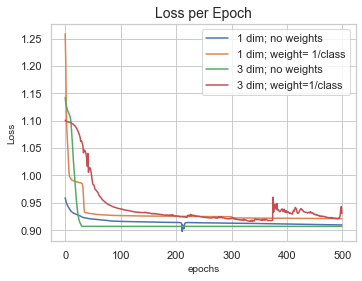

In [138]:
# Plot training results

f = plt.figure(figsize = (12,4))
ax1 = f.add_subplot(121)

p1 = ax1.plot(loss_1d_vals)
p2 = ax1.plot(loss_1d_w_vals)
p3 = ax1.plot(loss_3d_vals)
p4 = ax1.plot(loss_3d_w_vals)
ax1.set_ylabel('Loss', fontsize = 10)
ax1.set_xlabel('epochs', fontsize = 10)
ax1.legend((p1[0], p2[0], p3[0], p4[0]), ('1 dim; no weights', '1 dim; weight= 1/class', '3 dim; no weights', 
                                                       '3 dim; weight=1/class'))

ax1.set_title('Loss per Epoch', fontsize = 14)

## Test the models

In [139]:
# predict with already cleaned data (test_x)

def predict_test_data(model, test_data):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    test_data = test_data.to(device)
    
    if(len(test_data) == 0):
        "Your review must contain at least 1 word!"
        return None
    
    output, _ = model(test_data)
    pred = torch.round(output.squeeze())
    print(pred.size())
    results = []
    for i in pred:
        if i != 0:
            results.append('This is offensive language.') 
        else:
            results.append('This is hate speech or neutral.')
    
    return pred

# predict one sample tweet

def predict_sample_tweet(model, tweet):
    
    # data cleaning    

    tweet = lemmatize(tweet)
    tweet= create_doc_list(tweet)

    filtered_seq = filter_stopwords(tweet)

    unique_words_lg = uniqueWords(filtered_seq)
    seq_onehot_lg = onehot_encoder(filtered_seq, unique_words_lg)
    
    longest_tweet = 22
    
    zero_vector = np.repeat(0, np.shape(seq_onehot_lg[0])[1], axis=None)

    for i in range(len(seq_onehot_lg)):
        tweet_length = np.shape(seq_onehot_lg[i])[0]
        while tweet_length < longest_tweet:
            seq_onehot_lg[i].append(zero_vector)
            tweet_length = np.shape(seq_onehot_lg[i])[0] 
            
    seq_idx_lg = encoder_index(seq_onehot_lg)

    test_sequence = torch.from_numpy(np.asarray(seq_idx_lg))
    
    # predict sequence
    device = "cuda" if torch.cuda.is_available() else "cpu"

    test_sequence = test_sequence.to(device)
    
    if(len(test_sequence) == 0):
        "Your review must contain at least 1 word!"
        return None
    
    output, _ = model(test_sequence)
    output = output.to(device)
    pred = torch.round(output.squeeze())
    
    if pred == 0:
        result = "This is hate speech or neutral." 
    if pred == 1:
        result = "This is offensive language."
    
    return result

    
# Puts the data in the required format to plot the confusion matrix
def plot_confusion_matrix(cm, class_labels):
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    return(df_cm)

In [126]:
# prediction results

X_test = torch.from_numpy(np.asarray(X_test))
Y_test = torch.Tensor(np.asarray(Y_test))

# 3 layer losses

output_3d, _ = model_3d(X_test)
pred_3d = output_3d.squeeze()
loss_3d = criterion(output_3d, Y_test.long())

output_3d_w, _ = model_3d_w(X_test)
pred_3d_w = output_3d_w.squeeze()
loss_3d_w = criterion_weighted(output_3d_w, Y_test.long())

In [123]:
# 1 layer losses

output_1d, _ = model_1d(X_test)
pred_1d = output_1d.squeeze()
loss_1d = criterion(output_1d, Y_test.long())

output_1d_w, _ = model_1d_w(X_test)
pred_1d_w = output_1d_w.squeeze()
loss_1d_w = criterion_weighted(output_1d_w, Y_test.long())

In [133]:
# Put results in a dataframe
errors = {'Models': ['Model 1lnw', 'Model 1lw', 'Model 3lnw', 'Model 3lw'], 
          'Error': np.array([float(loss_1d), float(loss_1d_w), float(loss_3d), float(loss_3d_w)])}

results_df = pd.DataFrame(data=errors)

## Results

### Test Error Rates

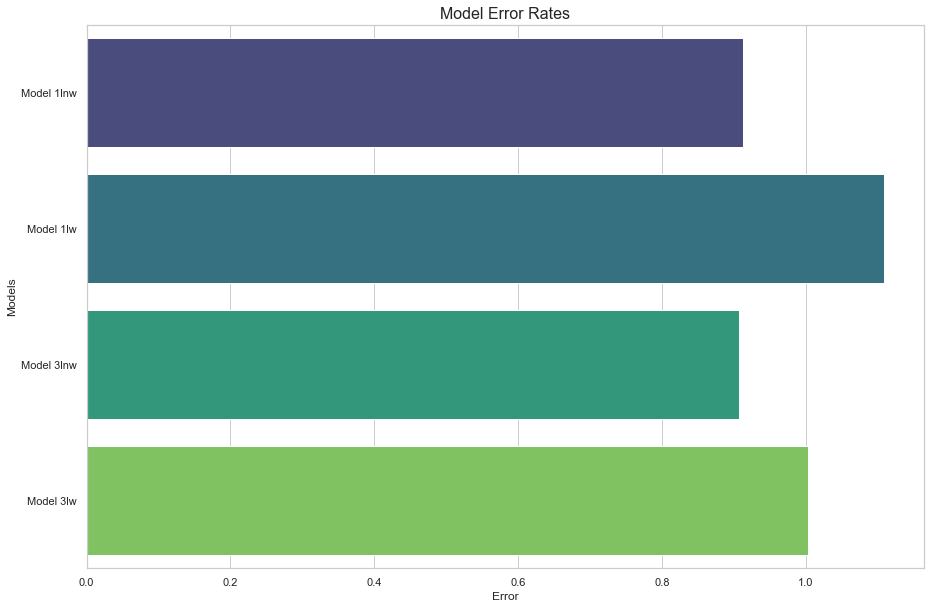

In [134]:
plt.figure(figsize=(15, 10))

sns.set(style='whitegrid')
ax = sns.barplot(x='Error', y='Models', data=results_df, palette='viridis').set_title('Model Error Rates', size=16)

### Confusion Matrices

In [141]:
# Convert the model output to a list of class labels
def labels(predicted_values):
    predicted_values.detach().numpy().tolist()
    labels = []
    for i in predicted_values:
        if i[0] == 1:
            lab = 0
        if i[1] == 1:
            lab = 1
        else:
            lab = 2
        labels.append(lab)
    return(labels)

pred_1d = labels(pred_1d)
pred_1d_w = labels(pred_1d_w)
pred_3d = labels(pred_3d)
pred_3d_w = labels(pred_3d_w)

Confusion Matrices


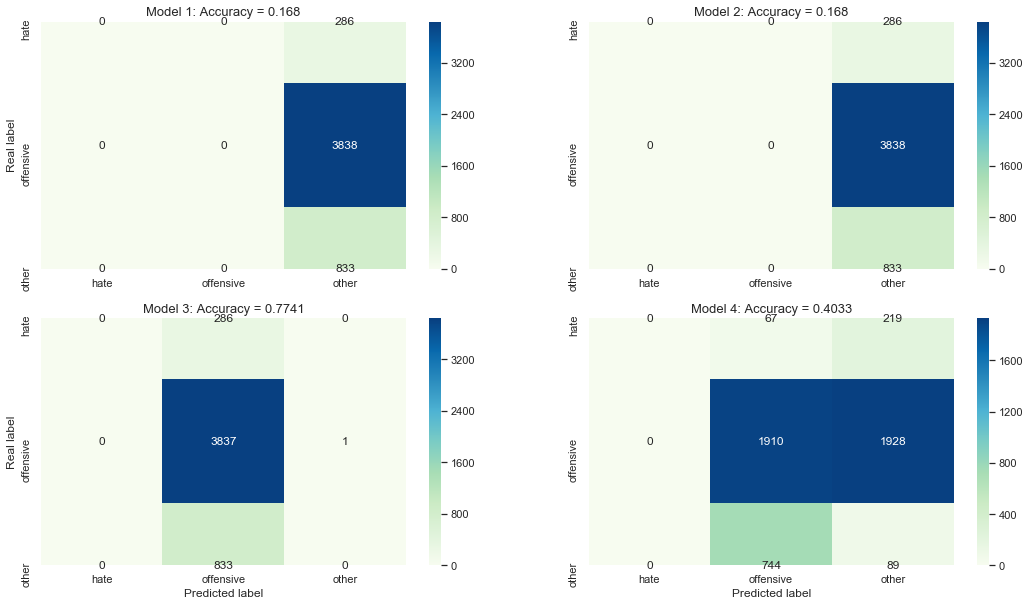

In [148]:
# Print the Confusion Matrices

y_test = Y_test.detach().numpy()

# Create the confusion matrix
class_labels = ['hate','offensive','other']
cm1=confusion_matrix(y_test,pred_1d)
cm2=confusion_matrix(y_test,pred_1d_w)
cm3=confusion_matrix(y_test,pred_3d)
cm4=confusion_matrix(y_test,pred_3d_w)

# Run the function to prepare the data to plot the confusion matrix
plt1 = plot_confusion_matrix(cm1, class_labels)
plt2 = plot_confusion_matrix(cm2, class_labels)
plt3 = plot_confusion_matrix(cm3, class_labels)
plt4 = plot_confusion_matrix(cm4, class_labels)


# Plot the confusion matrices
## Define figure size and axes
f = plt.figure(figsize = (18,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
## Plot the matrices
sns.heatmap(plt1, annot=True, fmt='d', cmap='GnBu', ax=ax1).set_title('Model 1: Accuracy = '+ str(round(accuracy_score(y_test,pred_1d),4)), size=13)
sns.heatmap(plt2, annot=True, fmt='d', cmap='GnBu', ax=ax2).set_title('Model 2: Accuracy = '+ str(round(accuracy_score(y_test,pred_1d_w),4)), size=13)
sns.heatmap(plt3, annot=True, fmt='d', cmap='GnBu', ax=ax3).set_title('Model 3: Accuracy = '+ str(round(accuracy_score(y_test,pred_3d),4)), size=13)
sns.heatmap(plt4, annot=True, fmt='d', cmap='GnBu', ax=ax4).set_title('Model 4: Accuracy = '+ str(round(accuracy_score(y_test,pred_3d_w),4)), size=13)
# Set axis labels
ax3.set_xlabel("Predicted label")
ax4.set_xlabel("Predicted label")
ax1.set_ylabel("Real label")
ax3.set_ylabel("Real label")

print("Confusion Matrices")